[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jonarod/Bootcamp-Inteligencia-Artificial-Women-Who-Code-Medellin/blob/master/semana%202/Simple%20ANN%20-%20Precio%20Casas/house_prices_ANN.ipynb)

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Librarias importadas')

Libraries are imported.


In [49]:
column_names = ["serial",	"fecha",	"edad",	"distancia",	"comercios",	"latitud",	"longitud",	"precio"]

# Importar desde Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# df = pd.read_csv('gdrive/My Drive/Pro/Women Who Code/Week 2/House Prices ANN/dataset_casas.csv', names = column_names )

# Bajar archivo con el ID link de Google Drive
# !gdown --id ""


# Importar desde Github

url = 'https://raw.githubusercontent.com/Jonarod/Bootcamp-Inteligencia-Artificial-Women-Who-Code-Medellin/master/semana%202/Simple%20ANN%20-%20Precio%20Casas/dataset_casas.csv'
df = pd.read_csv(url, names = column_names )


Mounted at /content/gdrive


In [50]:
df.head()

,serial,fecha,edad,distancia,comercios,latitud,longitud,precio
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


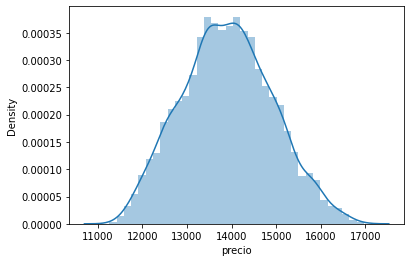

In [51]:
sns.distplot(df['precio'])

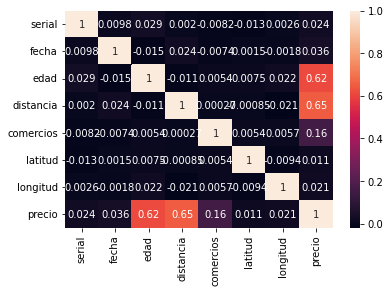

In [52]:
# Simple correlacion entre cada dimension
sns.heatmap(df.corr(),annot = True)

# Normalizacion de los datos

In [53]:
df = df.iloc[:,1:] 

# Creamos un nuevo dataframe "df_norm"
# Despues de sustraer el promedio a cada valor, dividimos el resultado por la deviacion estandar
df_norm = (df - df.mean()) / df.std()
df_norm.head()



,fecha,edad,distancia,comercios,latitud,longitud,precio
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


# Cuidado !!
A partir de aqui, `df_norm` contiene datos normalizados. Entonces, las predicciones tambien nos daran datos normalizados. Es necesario crear una funcion para convertir las predicciones a datos mas "entendibles".

In [55]:
y_mean = df['precio'].mean()
y_std = df['precio'].std()

# Funcion para convertir las predicciones de un valor normalizado a un valor real
def convert_label_value(pred):
    return int(pred * y_std + y_mean)

# Separacion de los sets de Entrenamiento Vs Prueba (Training set vs Test set)

In [56]:
# Sacamos del dataframe la columna "precio" ya que justamente es la valor a predecir
# Solo guardamos las demas dimensiones
X = df_norm.iloc[:, :6]
X.head()

,fecha,edad,distancia,comercios,latitud,longitud
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


In [57]:
# Recuerdan que es un problema SUPERVISADO !! NOSOTROS le tenemos que indicar al modelo, cada etiqueta (labels)
# Entonces, guardamos aqui las etiquetas (precio) 
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: precio, dtype: float64

A recordar: es habitual anotar las dimensiones de entrada con "X" mayuscula y las etiquetas con "Y" mayuscula. Lo veran seguido en libros y otros cursos, y en practica. 


In [58]:
# Guardamos los valores (no el dataframe)
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


In [59]:
# Separacion automatica de cada set
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0) 

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Creacion del modelo ANN

In [60]:
def get_model():
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'), # capa de entrada (Input Layer): 10 neurons 
        Dense(20, activation = 'relu'),                     # capa escondida (Hidden Layer): 20 neurons
        Dense(5, activation = 'relu'),                      # capa escondida (Hidden Layer): 5 neurons
        Dense(1)                                            # Capa de salida (Output Layer)
    ])

    model.compile(                                          # Parametros del 'Gradient Descent'
        loss='mse',                                         # Funcion de error: Mediana al cuadrado (Mean Square Error)
        optimizer='adam'                                    # Optimizador 'adam' (uno de los mas rapido)
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                70        
                                                                 
 dense_9 (Dense)             (None, 20)                220       
                                                                 
 dense_10 (Dense)            (None, 5)                 105       
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del modelo

In [61]:
model = get_model()

preds_on_untrained = model.predict(X_test) # Solo para guardar y comparar despues del entrenamiento



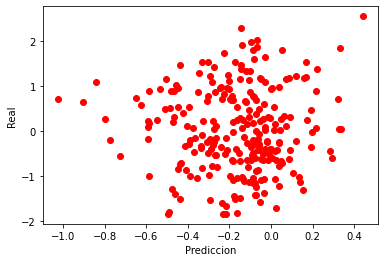

In [62]:
plt.plot(preds_on_untrained, y_test, 'o', color='red');
plt.xlabel("Prediccion");
plt.ylabel("Real");

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5) # Parar el modelo si 'val_loss' no baja despues de 5 epocas


history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
149/149 [==============================] - 1s 3ms/step - loss: 0.5652 - val_loss: 0.2308
Epoch 2/100
149/149 [==============================] - 0s 2ms/step - loss: 0.2019 - val_loss: 0.1802
Epoch 3/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1746 - val_loss: 0.1710
Epoch 4/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1673 - val_loss: 0.1659
Epoch 5/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1639 - val_loss: 0.1629
Epoch 6/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1611 - val_loss: 0.1590
Epoch 7/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1594 - val_loss: 0.1574
Epoch 8/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1581 - val_loss: 0.1596
Epoch 9/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1567 - val_loss: 0.1581
Epoch 10/100
149/149 [==============================] - 0s 2ms/step - loss: 0.1563 - val_lo

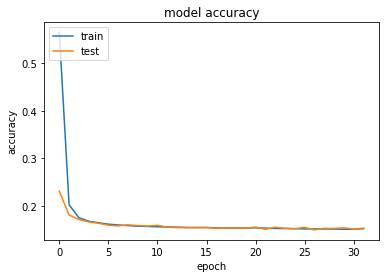

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


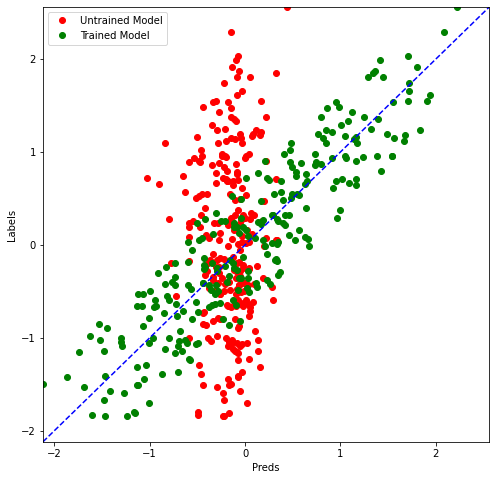

In [66]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

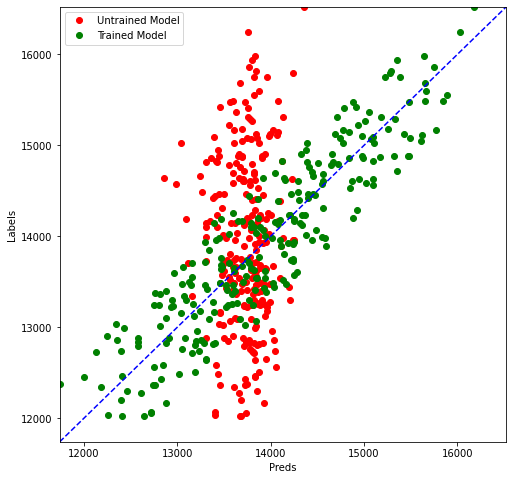

In [67]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)